In [31]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import math
import random

In [32]:
df = pd.read_csv("C:\\Users\\shrey\\OneDrive\\Documents\\.PES\\PIL\\sta-int_map.csv")
df.iloc[75310,1:13].astype(bool).sum(axis=0)

8

In [33]:
def get_int_map(dep):
    ap_index = {}
    df_1 = pd.read_csv("C:\\Users\\shrey\\OneDrive\\Documents\\.PES\\PIL\\sta-int_map.csv")
    dep = df_1.loc[df_1['deployment'] == dep]
    dep_reset = dep.reset_index(drop=True)
    aps_in_dep = dep_reset[dep_reset["node_type"] == 0]
    ap_index = {}
    for i in range(len(aps_in_dep)):
        ap_index[i] = aps_in_dep.index[i]
    aps = dep[dep["node_type"] == 0]
    #print(dep, aps, ap_index)
    
    #print(ap_index)
    #print("Lwngth: ", len(dep_reset.loc[ap_index[i], "int_map"]))
    for i in range(len(aps)-1):
        #print("i: ", i)
        for j in range(1, aps.index[i+1] - aps.index[i]):
            #print("j: ", j)
            for k in range(1, dep_reset.iloc[ap_index[i],1:13].astype(bool).sum(axis=0)):
                # STA interference for columns where currently value = 0: df.iloc[i, j] = df.iloc[i-1, j]*distance of i from j/distance of i from i-1
                # finding distance - with x (m) and y (m). Then, distance = sqrt(x^2 + y^2). distance(i, j) = sqrt((xj-xi)^2 + (yj-yi)^2)
                
                if(dep_reset.iloc[ap_index[i] + j, k] == 0):
                    # print("k: ", k)
                    # print(dep_reset.iloc[ap_index[i], k])
                    # print(dep_reset.iloc[ap_index[i] + j, 17]) 
                    # print(dep_reset.iloc[ap_index[i] + j, 18])
                    # print(dep_reset["x(m)"][ap_index[k-1]])
                    
                    #df.iloc[out2.index[i] + j, k] = df.iloc[out2.index[i], k]*math.sqrt((df.iloc[out2.index[i] + j, 17] - out["x(m)"][i+k])**2 + (df.iloc[out2.index[i] + j, 17] - out["y(m)"][i+k])**2)/math.sqrt((out2["x(m)"][i] - out["x(m)"][i+k])**2 + (out2["y(m)"][i] - out["y(m)"][i+k])**2)
                    dep_reset.iloc[ap_index[i] + j, k] = dep_reset.iloc[ap_index[i], k]*((dep_reset.iloc[ap_index[i] + j, 17] - dep_reset["x(m)"][ap_index[0] + ap_index[k-1]])**2 + 
                    (dep_reset.iloc[ap_index[i] + j, 18] - dep_reset["y(m)"][ap_index[0] + ap_index[k-1]])**2)/((dep_reset.iloc[ap_index[i], 17] - dep_reset["x(m)"][ap_index[0] + ap_index[k-1]])**2 + (dep_reset.iloc[ap_index[i], 18] - dep_reset["y(m)"][ap_index[0] + ap_index[k-1]])**2)

    i = len(aps) - 1
    for j in range(1, dep.index[len(dep)-1] - aps.index[i]+1):
            #print("j: ", j)
            for k in range(1, dep_reset.iloc[ap_index[i],1:13].astype(bool).sum(axis=0)):
                # STA interference for columns where currently value = 0: df.iloc[i, j] = df.iloc[i-1, j]*distance of i from j/distance of i from i-1
                # finding distance - with x (m) and y (m). Then, distance = sqrt(x^2 + y^2). distance(i, j) = sqrt((xj-xi)^2 + (yj-yi)^2)
                
                if(dep_reset.iloc[ap_index[i] + j, k] == 0):
                    # print("Last part: ")
                    # print("k: ", k)
                    # print(dep_reset.iloc[ap_index[i], k])
                    # print(dep_reset.iloc[ap_index[i] + j, 17]) 
                    # print(dep_reset.iloc[ap_index[i] + j, 18])
                    # print(dep_reset["x(m)"][ap_index[0] + ap_index[k-1]])
                    # print(dep_reset.iloc[ap_index[i], 17] - dep_reset["x(m)"][ap_index[0] + ap_index[k-1]])
                    
                    #df.iloc[out2.index[i] + j, k] = df.iloc[out2.index[i], k]*math.sqrt((df.iloc[out2.index[i] + j, 17] - out["x(m)"][i+k])**2 + (df.iloc[out2.index[i] + j, 17] - out["y(m)"][i+k])**2)/math.sqrt((out2["x(m)"][i] - out["x(m)"][i+k])**2 + (out2["y(m)"][i] - out["y(m)"][i+k])**2)
                    dep_reset.iloc[ap_index[i] + j, k] = dep_reset.iloc[ap_index[i], k]*math.sqrt((dep_reset.iloc[ap_index[i] + j, 17] - dep_reset["x(m)"][ap_index[0] + ap_index[k-1]])**2 + 
                    (dep_reset.iloc[ap_index[i] + j, 18] - dep_reset["y(m)"][ap_index[0] + ap_index[k-1]])**2)/math.sqrt((dep_reset.iloc[ap_index[i], 17] - dep_reset["x(m)"][ap_index[0] + ap_index[k-1]])**2 + (dep_reset.iloc[ap_index[i], 18] - dep_reset["y(m)"][ap_index[0] + ap_index[k-1]])**2)

    return dep_reset

In [34]:
dep = get_int_map(799)

In [35]:
dep.to_csv("trial2.csv")

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [37]:
# Creating individual graphs
# This assumes all APs and STAs are connected to each other
def create_graph(split, split_y, deployment):
    dep = get_int_map(deployment)
    
    dep_y = dep["throughput"]
    dep_x = dep[['0', '1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', 'wlan_code_index', 'x(m)', 'y(m)',
            'primary_channel', 'min_channel_allowed', 'max_channel_allowed', 'RSSI', 'node_type',
            'SINR', 'average_airtime', 'deployment']]
    #print(dep_x)
    dep_reset = dep.reset_index(drop=True)
    ap_index = {}
    out = dep_reset[dep_reset["node_type"] == 0]
    for i in range(len(out)):
        ap_index[out.index[i]] = i
    #print(ap_index)
    node_features = dep_x.iloc[:,12:].values
    #edge_features = dep.iloc[:,:12].values - here each node has been given an edge feature
    # need to give each edge an edge feature
    node_targets = dep_y.values
    node_features = torch.tensor(node_features, dtype=torch.float)
    print(node_features.shape)
    #edge_features = torch.tensor(edge_features, dtype=torch.float)
    node_targets = torch.tensor(node_targets, dtype=torch.float)
    # Add edges here for each deployment
    edges = []
    edge_features = []
    edge_index = []
    for i in range(len(dep)):
        for j in range(len(dep)):
            if (i != j and (dep["node_type"].iloc[i] == 0 and dep["node_type"].iloc[j] == 0)) or (i !=j and (dep["node_type"].iloc[i] == 1 and dep["node_type"].iloc[j] == 0)):
                edges.append([i,j])
    #print(edges)
    edges = torch.tensor(edges, dtype=torch.float)
    #print("Edges: ", edges, edges.shape)
    edge_index = torch.tensor(edges, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    #print(edges.detach(), edges.shape)
    
    for i in range(edges.shape[0]):
        #print(i)
        edge_features.append(dep.iloc[int(edges[i][0]), ap_index[int(edges[i][1])]])
    edge_features = torch.tensor(edge_features, dtype=torch.float).unsqueeze(1)
    #print(edge_features, edge_features.shape)
    graph = {
        "edges": edges,
        "edge_index": edge_index,
        "node_features": node_features,
        "edge_features": edge_features,
        "node_targets": node_targets
    }
    return graph

In [38]:
print(create_graph(0, 0 , 0))

torch.Size([177, 11])
{'edges': tensor([[  0.,  15.],
        [  0.,  27.],
        [  0.,  45.],
        ...,
        [176., 135.],
        [176., 150.],
        [176., 163.]]), 'edge_index': tensor([[  0,   0,   0,  ..., 176, 176, 176],
        [ 15,  27,  45,  ..., 135, 150, 163]]), 'node_features': tensor([[0.0000e+00, 1.0000e+01, 1.0000e+01,  ..., 2.9620e+01, 9.5745e+01,
         0.0000e+00],
        [0.0000e+00, 7.1300e-02, 1.0808e+01,  ..., 2.9360e+01, 9.5745e+01,
         0.0000e+00],
        [0.0000e+00, 1.9627e+00, 4.1427e+00,  ..., 2.9480e+01, 9.5745e+01,
         0.0000e+00],
        ...,
        [1.1000e+01, 6.6595e+01, 5.5642e+01,  ..., 3.5400e+01, 9.4855e+01,
         0.0000e+00],
        [1.1000e+01, 6.3075e+01, 4.3863e+01,  ..., 2.9680e+01, 9.4855e+01,
         0.0000e+00],
        [1.1000e+01, 6.8264e+01, 5.0447e+01,  ..., 5.0690e+01, 9.4855e+01,
         0.0000e+00]]), 'edge_features': tensor([[10000.0000],
        [  -79.3400],
        [ -103.9600],
        ...,
   

C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


In [39]:
def create_geometric_graph(graph):
    data = Data(
        # Input graph.
        x=graph["node_features"],
        #pos=pos,
        edge_index=graph["edge_index"],
        edge_attr=graph["edge_features"],
        # Output node targets.
        y=graph["node_targets"],
        num_nodes = len(graph["node_features"])
        #y_mask=y_mask,
        # Utilities.
        #node_ap=node_ap,
        # Referencing
        #scenario=graph['scenario'],
        #deployment=graph['deployment'],
    )

    return data

In [40]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

class EdgeModel(torch.nn.Module):
    def __init__(self, n_node_features, n_edge_features, hiddens, n_targets):
        super().__init__()
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * n_node_features + n_edge_features, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, n_targets),
        )

    def forward(self, src, dest, edge_attr, u=None, batch=None):
        #print("In edge model")
        #print(src, src.shape)
        #print(dest, dest.shape)
        #print(edge_attr, edge_attr.shape)
        out = torch.cat([src, dest, edge_attr], 1)
        out = self.edge_mlp(out)
        #print("Exit edge model")
        return out


class NodeModel(torch.nn.Module):
    def __init__(self, n_node_features, hiddens, n_targets):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = torch.nn.Sequential(
            torch.nn.Linear(n_node_features + hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
        )
        self.node_mlp_2 = torch.nn.Sequential(
            torch.nn.Linear(n_node_features + hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, n_targets),
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        #print("In node model")
        row, col = edge_index
        out = torch.cat([x[col], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        out = self.node_mlp_2(out)
        #print("Exit node model")
        return out


class MetaNet(torch.nn.Module):
    def __init__(self, n_node_features, n_edge_features, num_hidden):
        super(MetaNet, self).__init__()

        # Input Layer
        self.input = MetaLayer(
            edge_model=EdgeModel(
                n_node_features=n_node_features, n_edge_features=n_edge_features,
                hiddens=num_hidden, n_targets=num_hidden),
            node_model=NodeModel(n_node_features=n_node_features, hiddens=num_hidden, n_targets=num_hidden)
            )

        # Output Layer
        self.output = MetaLayer(
            edge_model=EdgeModel(
                n_node_features=num_hidden, n_edge_features=num_hidden,
                hiddens=num_hidden, n_targets=num_hidden),
            node_model=NodeModel(n_node_features=num_hidden, hiddens=num_hidden, n_targets=1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, y = data.x, data.edge_index, data.edge_attr, data.y
        #print("In meta model")
        x, edge_attr, _ = self.input(x, edge_index, edge_attr)
        x = F.relu(x)
        #x = F.dropout(x, p=0.2, training=self.training)
        x, edge_attr, _ = self.output(x, edge_index, edge_attr)
        #x = F.dropout(x, p=0.5, training=self.training)
        #print("Exit meta model")
        return x


In [41]:
num_node_features = 11
num_edge_features = 1
num_hidden = 128

In [42]:
model = MetaNet(num_node_features, num_edge_features, num_hidden).to(device)


In [43]:
def train(dataset):
    # Monitor training.
    losses = []

    # Put model in training mode!
    model.train()
    i=0
    for i, batch in enumerate(dataset):
        #print("misaa")
        # Training step.
    
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = torch.sqrt(F.mse_loss(out.squeeze(), batch.y.squeeze()))
        #print(f"Training oss for {i}: {loss}")
        loss.backward()
        optimizer.step()
        # Monitoring
        losses.append(loss.item())
        if(i == 559): break
    # Return training metrics.
    return losses


def evaluate(dataset):
    # Monitor evaluation.
    losses = []
    rmse = []

    # Validation (1)
    model.eval()
    i = 0
    for i, batch in enumerate(dataset):
        batch = batch.to(device)

        # Calculate validation losses.
        out = model(batch)
        loss = torch.sqrt(F.mse_loss(out.squeeze(), batch.y.squeeze()))

        # Metric logging.
        losses.append(loss.item())
        #rmse.append(rmse_batch.item())
        if(i == 159): break
    return losses

In [44]:
# With train, validation and test data.
from torch_geometric.data import InMemoryDataset, download_url, extract_zip
# divide into training and testing points
class CustomDataset(InMemoryDataset):
    def __init__(self, root, split="train", transform=None):
        self.data = pd.read_csv("sta-int_map.csv")
        self.split = split
        super(CustomDataset, self).__init__(root, split, transform)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        #self.data = pd.read_csv("deployment_with_int_map.csv")
        #self.data, self.slices = pd.read_csv("deployment_with_int_map.csv")
        
        print("In init")
    
    @property
    def raw_file_names(self):
        print("In raw_file_names")
        return ["sta-int_map.csv"]

    @property
    def processed_file_names(self):
        print("In processed_file_names")
        li = ['data_train_' + str(i) + '.pt' for i in range(560)]+ ['data_valid_' + str(j) + '.pt' for j in range(560, 720)] + ['data_test_' + str(k) + '.pt' for k in range(720, 800)]
        #print(li)
        return ['data_train_' + str(i) + '.pt' for i in range(560)]+ ['data_valid_' + str(j) + '.pt' for j in range(160)] + ['data_test_' + str(k) + '.pt' for k in range(80)]
        
    def _download(self):
        '''
        print("In download")
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        # The zip file is removed
        os.unlink(path)
        '''
        pass

    def process(self):
        print("In process")
        #df = pd.read_csv(self.raw_paths[0])
        X = self.data[['0', '1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', 'wlan_code_index', 'x(m)', 'y(m)',
            'primary_channel', 'min_channel_allowed', 'max_channel_allowed', 'node_type',
            'SINR', 'average_airtime', 'deployment']]
        y = self.data.loc[:, ["throughput", "deployment"]]
        X_train = X.iloc[:75327, :]
        X_valid = X.iloc[75327:82674, :]
        X_test = X.iloc[82674:,:]
        print(X_test.columns)
        y_train = y.iloc[:75327]
        y_valid = y.iloc[75327:82674]
        y_test = y.iloc[82674:]
        graphs = []
        print("Here")
        l = [i for i in range(800)]
        self.l_train = random.sample(l, 560)
        l = [x for x in l if x not in self.l_train]
        self.l_valid = random.sample(l, 160)
        l = [x for x in l if x not in self.l_valid]
        self.l_test = l
        count = 0
        if(self.split == "train"):
            
            for i in self.l_train:
                
                #X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float)
                #y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float)
                graph = create_graph(X_train, y_train, i)
                
                graph = create_geometric_graph(graph)
                graphs.append(graph)

                torch.save(graph, os.path.join(self.processed_dir, f'data_train_{count}.pt'))
                count += 1
        elif(self.split == "valid"):
            for i in self.l_valid:
                #X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float)
                #y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float)
                graph = create_graph(X_valid, y_valid, i)
                graph = create_geometric_graph(graph)
                graphs.append(graph)
            
                torch.save(graph, os.path.join(self.processed_dir, f'data_valid_{count}.pt'))  
                count += 1
        else:
            for i in self.l_test:
                #X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float)
                #y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float)
                graph = create_graph(X_test, y_test, i)
                graph = create_geometric_graph(graph)
                graphs.append(graph)
            
                torch.save(graph, os.path.join(self.processed_dir, f'data_test_{count}.pt'))
                count += 1  
        #return graphs[idx]
    
    def __len__(self):
        if(self.split == "train"):
            #return len(self.processed_file_names[0])
            return 560
        elif self.split == "valid":
            return 160
        else:
            return 80
    
    def __getitem__(self, idx):
        #print("Part: ", self.processed_file_names[1])
        
        if(self.split == "train"):
            data = torch.load(os.path.join(self.processed_dir, f'data_train_{idx}.pt'))
        elif(self.split == "valid"):
            data = torch.load(os.path.join(self.processed_dir, f'data_valid_{idx}.pt'))
        elif (self.split=="test"):
            data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
        return data

In [45]:
os.chdir("C:\\Users\\shrey\\OneDrive\\Documents\\.PES\PIL")


In [46]:
dataset_train = CustomDataset(root="C:\\Users\\shrey\\OneDrive\\Documents\\.PES\PIL/", split='train')
dataset_valid = CustomDataset(root="C:\\Users\\shrey\\OneDrive\\Documents\\.PES\PIL/", split='valid')
dataset_test = CustomDataset(root="C:\\Users\\shrey\\OneDrive\\Documents\\.PES\PIL/", split='test')

In processed_file_names
In process
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'wlan_code_index', 'x(m)', 'y(m)', 'primary_channel',
       'min_channel_allowed', 'max_channel_allowed', 'node_type', 'SINR',
       'average_airtime', 'deployment'],
      dtype='object')
Here


Processing...


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([40, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([224, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([20, 11])
torch.Size([45, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([19, 11])
torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([208, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([176, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([22, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([190, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([193, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([55, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([211, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([187, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([58, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([49, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([190, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([170, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([45, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([190, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([178, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([28, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([210, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([175, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([165, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([197, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([36, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([204, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([210, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([79, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([193, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([25, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([187, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([47, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([201, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([207, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([201, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([20, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([59, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([29, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([193, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([208, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([33, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([81, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([32, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([23, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([41, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([201, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([39, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([205, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([42, 11])
torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([187, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([56, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])
torch.Size([36, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([208, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([58, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([176, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([37, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([169, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([37, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([78, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([78, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([178, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([207, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([22, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])
torch.Size([42, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([175, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([38, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([166, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([177, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([49, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([48, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([39, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([40, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([197, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([165, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([59, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([170, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([55, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([34, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([174, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([48, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([26, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([206, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([79, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([34, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([47, 11])
torch.Size([34, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([83, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([35, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([173, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([22, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([206, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([82, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([50, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([58, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([40, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([177, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([18, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([178, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([204, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([26, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([216, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([79, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([179, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([35, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])
torch.Size([37, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([174, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([28, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([183, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([47, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([78, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([178, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([193, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([209, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([208, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([217, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([81, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([177, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([54, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([215, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([206, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([168, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([206, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([27, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([33, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([183, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([52, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([58, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([169, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([59, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([204, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([214, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([31, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([38, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([172, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([211, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([207, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([167, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([216, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([205, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([207, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([33, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([190, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])
torch.Size([35, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([197, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([217, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([179, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([58, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([187, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([32, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([209, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([210, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([179, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([213, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([197, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([178, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([32, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([63, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([183, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([83, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([41, 11])
In init
In processed_file_names


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
Done!
Processing...


In process
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'wlan_code_index', 'x(m)', 'y(m)', 'primary_channel',
       'min_channel_allowed', 'max_channel_allowed', 'node_type', 'SINR',
       'average_airtime', 'deployment'],
      dtype='object')
Here
torch.Size([40, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([174, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([183, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([177, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([209, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([169, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([39, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([78, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([56, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([207, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([175, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([206, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([190, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([26, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([20, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([40, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([211, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([51, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([36, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([59, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([46, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([190, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([55, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([28, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([41, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])
torch.Size([19, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([208, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([177, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([215, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([48, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([172, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([194, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([187, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([42, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([207, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([208, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([79, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([18, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([175, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([179, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([60, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([177, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([206, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([57, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([202, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([29, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([198, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([201, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])
In init


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
Done!


In processed_file_names
In process
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'wlan_code_index', 'x(m)', 'y(m)', 'primary_channel',
       'min_channel_allowed', 'max_channel_allowed', 'node_type', 'SINR',
       'average_airtime', 'deployment'],
      dtype='object')
Here


Processing...


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([183, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([199, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([182, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([197, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([203, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([184, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([181, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([216, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([204, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([196, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([214, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([192, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([185, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([186, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([201, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([180, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([188, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([195, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([169, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([191, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([189, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([200, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([75, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([73, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([71, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([66, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([70, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([72, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([74, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([62, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([76, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([65, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([67, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([68, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([77, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([64, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([16, 11])
torch.Size([22, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([33, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([30, 11])
torch.Size([30, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([18, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([61, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([49, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([43, 11])
torch.Size([32, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([45, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([40, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([59, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([58, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([48, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([79, 11])


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


torch.Size([69, 11])
In init


C:\Users\shrey\AppData\Local\Temp\ipykernel_7752\1426162578.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)
Done!


In [47]:
from sklearn.utils import shuffle
from torch_geometric.data import DataLoader
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=3, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

c:\Python310\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Metrics recorder per epoch.
train_losses = []

valid_losses = []
valid_losses_corrected = []

# Training loop.
model.train()
for epoch in range(5000):
    # Train.
    train_epoch_losses = train(train_loader)
    print(f"Epoch: {epoch}, Len of Training loss: {len(train_epoch_losses)}, Average loss: {float(np.sum(train_epoch_losses))/len(train_epoch_losses)}")
    train_losses.append(np.mean(train_epoch_losses))

    valid_epoch_losses= evaluate(valid_loader)
    print(f"Len of Validation loss: {len(valid_epoch_losses)}, Average loss: {float(np.sum(valid_epoch_losses))/len(valid_epoch_losses)}")
    valid_losses.append(np.mean(valid_epoch_losses))

Epoch: 0, Len of Training loss: 18, Average loss: 27.949796358744305
Len of Validation loss: 54, Average loss: 26.843507766723633
Epoch: 1, Len of Training loss: 18, Average loss: 26.0985008875529
Len of Validation loss: 54, Average loss: 24.0454852492721
Epoch: 2, Len of Training loss: 18, Average loss: 23.106643358866375
Len of Validation loss: 54, Average loss: 25.867083584820783
Epoch: 3, Len of Training loss: 18, Average loss: 21.456239806281197
Len of Validation loss: 54, Average loss: 20.20924788934213
Epoch: 4, Len of Training loss: 18, Average loss: 19.408234066433376
Len of Validation loss: 54, Average loss: 18.384470339174623
Epoch: 5, Len of Training loss: 18, Average loss: 20.433975484636093
Len of Validation loss: 54, Average loss: 22.56856695810954
Epoch: 6, Len of Training loss: 18, Average loss: 20.815102312299942
Len of Validation loss: 54, Average loss: 18.67083553031639
Epoch: 7, Len of Training loss: 18, Average loss: 17.617582321166992
Len of Validation loss: 54, 

In [49]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
## Metrics recorder per epoch.
#train_losses = []
#
#valid_losses = []
#valid_losses_corrected = []
#
## Training loop.
#model.train()
#for epoch in range(3000):
#    # Train.
#    train_epoch_losses = train(train_loader)
#    print(f"Epoch: {epoch}, Len of Training loss: {len(train_epoch_losses)}, Average loss: {float(np.sum(train_epoch_losses))/len(train_epoch_losses)}")
#    train_losses.append(np.mean(train_epoch_losses))
#
#    valid_epoch_losses= evaluate(valid_loader)
#    print(f"Len of Validation loss: {len(valid_epoch_losses)}, Average loss: {float(np.sum(valid_epoch_losses))/len(valid_epoch_losses)}")
#    valid_losses.append(np.mean(valid_epoch_losses))

In [50]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
## Metrics recorder per epoch.
#train_losses = []
#
#valid_losses = []
#valid_losses_corrected = []
#
## Training loop.
#model.train()
#for epoch in range(3000):
#    # Train.
#    train_epoch_losses = train(train_loader)
#    print(f"Epoch: {epoch}, Len of Training loss: {len(train_epoch_losses)}, Average loss: {float(np.sum(train_epoch_losses))/len(train_epoch_losses)}")
#    train_losses.append(np.mean(train_epoch_losses))
#
#    valid_epoch_losses= evaluate(valid_loader)
#    print(f"Len of Validation loss: {len(valid_epoch_losses)}, Average loss: {float(np.sum(valid_epoch_losses))/len(valid_epoch_losses)}")
#    valid_losses.append(np.mean(valid_epoch_losses))

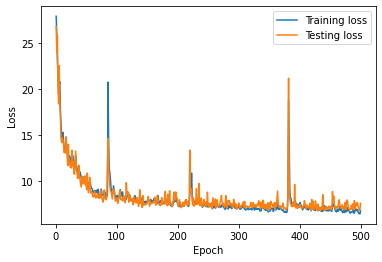

In [51]:
num_epochs = 500

plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_losses[:500], label="Training loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), valid_losses[:500], label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

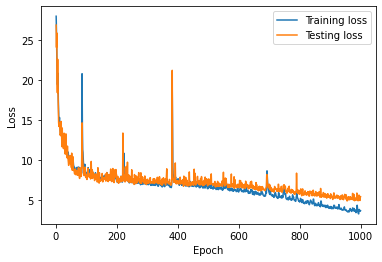

In [52]:
num_epochs = 1000

plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_losses[:1000], label="Training loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), valid_losses[:1000], label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

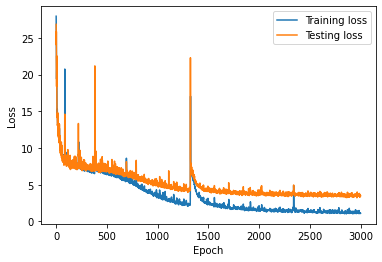

In [53]:
num_epochs = 3000

plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_losses[:3000], label="Training loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), valid_losses[:3000], label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

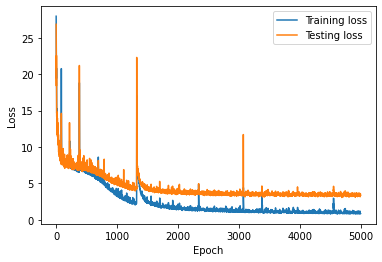

In [54]:
num_epochs = 5000

plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_losses[:5000], label="Training loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), valid_losses[:5000], label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [55]:
df = pd.read_csv("C:\\Users\\shrey\\OneDrive\\Documents\\.PES\\PIL\\sta-int_map.csv")
# Shuffle the different deployments in the dataset while keeping all the rows within a particular deployment in thw same order.
df = df.sample(frac=1).reset_index(drop=True)
df
#groups = [df.sample(frac = 1) for _,df in df.groupby('deployment')]
#df = pd.concat(groups)
#df


,Unnamed: 0.2,0,1,2,3,4,5,6,7,8,...,min_channel_allowed,max_channel_allowed,RSSI,SINR,throughput,average_airtime,average_interference,wlan_code_index,deployment,int_map
0,44482,0.00,0.00,0.00,-60.88,0.00,0.00,0.00,0.00,0.00,...,0,3,-60.880000,25.11,4.30,42.32250,0.000000,3,232.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,16635,0.00,0.00,0.00,0.00,0.00,-66.54,0.00,0.00,0.00,...,0,3,-66.540000,14.94,0.23,2.46750,0.000000,5,86.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,20040,0.00,0.00,0.00,0.00,0.00,0.00,-61.80,0.00,0.00,...,0,3,-61.800000,16.91,0.61,7.97500,0.000000,6,104.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,76988,0.00,0.00,0.00,0.00,-63.55,0.00,0.00,0.00,0.00,...,0,7,-63.550000,15.95,1.38,16.87625,0.000000,4,584.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,44786,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,7,-48.520000,35.54,6.76,20.48875,0.000000,10,233.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87904,48368,0.00,0.00,0.00,-48.39,0.00,0.00,0.00,0.00,0.00,...,0,7,-48.390000,39.49,15.59,42.73625,0.000000,3,252.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
87905,36779,0.00,0.00,-64.90,0.00,0.00,0.00,0.00,0.00,0.00,...,0,3,-64.900000,24.61,4.22,21.88250,0.000000,2,192.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
87906,49773,-97.33,-87.05,-91.31,-104.10,-79.43,-70.58,-82.44,-99.68,-75.93,...,4,5,-54.071875,29.13,126.83,82.01500,-86.768182,9,259.0,"[-97.33, -87.05, -91.31, -104.1, -79.43, -70.5..."
87907,73045,0.00,0.00,0.00,0.00,-60.64,0.00,0.00,0.00,0.00,...,6,7,-60.640000,32.34,5.81,84.73500,0.000000,4,526.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [56]:
with torch.no_grad():
    model.eval()
    losses = []
    for i, batch in enumerate(test_loader):
        batch = batch.to(device)

        # Calculate validation losses.
        out = model(batch)
        loss = torch.sqrt(F.mse_loss(out.squeeze(), batch.y.squeeze()))

        # Metric logging.
        losses.append(loss.item())
        #rmse.append(rmse_batch.item())
        if(i == 79): break
    print(f"Len of Testing loss: {len(losses)}, Average loss: {float(np.sum(losses))/len(losses)}")

Len of Testing loss: 80, Average loss: 3.418294843286276
